# Code for post Neural Network from the beginnings

https://rorjor.wixsite.com/empoweredatascience

In [ ]:
# Data load
from sklearn.datasets import load_boston
houses = load_boston()

data = houses.data
features = houses.feature_names
target = houses.target

In [ ]:
# Data additional info: https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html
houses.feature_names

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

In [ ]:
# Data preparation
from sklearn.preprocessing import StandardScaler
s = StandardScaler()
data = s.fit_transform(data)

In [ ]:
# Build train, test data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3)
# reshape y to 1 column
y_train, y_test = y_train.reshape(-1, 1), y_test.reshape(-1, 1)

In [ ]:
# Apply regression model
from sklearn.linear_model import LinearRegression

lr = LinearRegression(fit_intercept=True)
lr.fit(X_train, y_train)
preds = lr.predict(X_test)

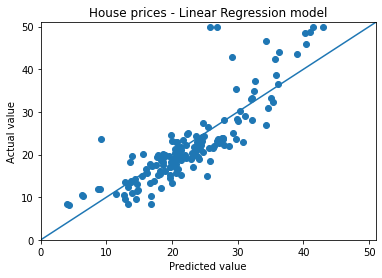

In [ ]:
# Plot regression results
import matplotlib.pyplot as plt

plt.xlabel("Predicted value")
plt.ylabel("Actual value")
plt.title("House prices - Linear Regression model")
plt.xlim([0, 51])
plt.ylim([0, 51])
plt.scatter(preds, y_test)
plt.plot([0, 51], [0, 51]);

In [ ]:
# Calculate metric MSE and MAE
from sklearn.metrics import mean_squared_error, mean_absolute_error

print('MSE: ', mean_squared_error(y_test, preds, squared=True)) # MSE 
print('RMSE: ', mean_squared_error(y_test, preds, squared=False)) # if squared=False => RMSE
print('MAE: ', mean_absolute_error(y_test, preds))

MSE:  25.477930504169446
RMSE:  5.047566790461464
MAE:  3.567055818209399


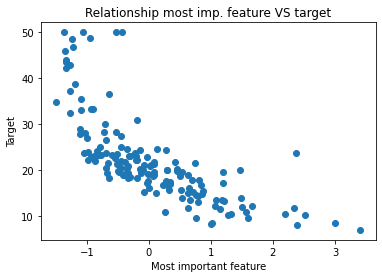

In [ ]:
# Plot Non linear relation - most important feature = LSTAT (last-12)
plt.scatter(X_test[:, 12], y_test)
plt.xlabel("Most important feature")
plt.ylabel("Target")
plt.title("Relationship most imp. feature VS target");

**Our first Neural network**

**PyTorch** is the ability to define models and layers as easy-to-use
objects that handle sending gradients backward and storing parameters automatically, simply by having them inherit from the *torch.nn.Module* class.

we need the ability to change our model’s behavior depending on whether we are running it in training mode or in inference mode (Evaluation mode). 
In PyTorch, we can switch a model or layer from training mode (its default behavior) to inference mode by running *m.eval* on the model

---



In [ ]:
from torch import nn, Tensor, sigmoid
import torch.optim.optimizer as Optimizer
import torch.optim as optim
import torch.nn.modules.loss as _Loss
import numpy as np
from typing import Tuple

def inference_mode(m: nn.Module):
  m.eval()

# NN Model base class
class PyTorchModel(nn.Module):
  def __init__(self) -> None:
    super().__init__()
    
  def forward(self, x: Tensor, inference: bool = False) -> Tensor:
    if inference:
      self.apply(inference_mode)
    raise NotImplementedError()

# NN Model to predict House prices - subclass of base
class HousePricesModel(PyTorchModel):
  # set default 13 features for the output of hidden layer
  # and the input of output layer
  def __init__(self, hidden_size: int = 13):
    super().__init__()
    self.fc1 = nn.Linear(13, hidden_size)
    self.fc2 = nn.Linear(hidden_size, 1)

  def forward(self, x: Tensor) -> Tensor:
    assert_dim(x, 2)
    assert x.shape[1] == 13

    x = self.fc1(x)
    x = sigmoid(x)
    return self.fc2(x)

In [ ]:
def permute_data(X: np.ndarray, y: np.ndarray):
    perm = np.random.permutation(X.shape[0])
    return X[perm], y[perm]

In [ ]:
def assert_dim(t: np.ndarray, dim: int):
    assert t.ndim == dim, \
        '''
        Tensor expected dimension {0}, but has dimension {1}
        '''.format(dim, len(t.shape))    
    return None

In [ ]:
pt_houses_model = HousePricesModel()
pt_houses_model

HousePricesModel(
  (fc1): Linear(in_features=13, out_features=13, bias=True)
  (fc2): Linear(in_features=13, out_features=1, bias=True)
)

In [ ]:
# Build a trainer class
class PyTorchTrainer(object):
  def __init__(self, model: PyTorchModel, optim: Optimizer, criterion: _Loss):
    self.model = model
    self.optim = optim
    self.loss = criterion
    self._check_optim_net_aligned()

  # check that the parameters that the Optimizer refers
  # to are in fact the same as the model’s parameters
  def _check_optim_net_aligned(self):
    assert self.optim.param_groups[0]['params']\
    == list(self.model.parameters())

  def _generate_batches(self,
                        X: Tensor,
                        y: Tensor,
                        size: int = 32) -> Tuple[Tensor]:
    N = X.shape[0]
    for ii in range(0, N, size):
      X_batch, y_batch = X[ii:ii+size], y[ii:ii+size]
      yield X_batch, y_batch
  
  def fit(self, X_train: Tensor, y_train: Tensor,
        X_test: Tensor, y_test: Tensor,
        epochs: int=50,
        # eval_every: int=10,
        batch_size: int=32):
  
    for e in range(epochs):

      # On each epoch we shuffle the array elements randomly
      X_train, y_train = permute_data(X_train, y_train)
      # Generate the batches of data
      batch_generator = self._generate_batches(X_train, y_train, batch_size)

      # On each batch of data, backpropagate and perform the gradient descent
      for ii, (X_batch, y_batch) in enumerate(batch_generator):
                
        # Because Optimizer retains the parameter gradients (param_grads) 
        # after each iteration, set the previously calculated gradients to 0
        self.optim.zero_grad()
        # Feed the outputs and targets into a loss function to compute loss
        output = self.model(X_batch)
        # Compute the loss gradient with respect to all of the parameters
        loss = self.loss(output, y_batch)
        # After computing the loss value, started the backpropagation
        loss.backward()
        # Use the Optimizer to update the parameters according to some rule
        self.optim.step()

      output = self.model(X_test)
      # Calculate and print the loss of the epoch
      loss = self.loss(output, y_test)
      print(e, loss)

In [ ]:
# Pass our data to Tensors
X_train, X_test, y_train, y_test = Tensor(X_train), Tensor(X_test), Tensor(y_train), Tensor(y_test)

In [ ]:
# build an object model
nn_obj = HousePricesModel()
# build SGD optimizer
optimizer = optim.SGD(nn_obj.parameters(), lr=0.001)
# Loss function MSE
criterion = nn.MSELoss()

trainer = PyTorchTrainer(nn_obj, optimizer, criterion)
trainer.fit(X_train, y_train, X_test, y_test, epochs=200)

0 tensor(499.3207, grad_fn=<MseLossBackward>)
1 tensor(417.2307, grad_fn=<MseLossBackward>)
2 tensor(349.0024, grad_fn=<MseLossBackward>)
3 tensor(286.2938, grad_fn=<MseLossBackward>)
4 tensor(232.7984, grad_fn=<MseLossBackward>)
5 tensor(188.5711, grad_fn=<MseLossBackward>)
6 tensor(151.9245, grad_fn=<MseLossBackward>)
7 tensor(123.3584, grad_fn=<MseLossBackward>)
8 tensor(102.4077, grad_fn=<MseLossBackward>)
9 tensor(85.7833, grad_fn=<MseLossBackward>)
10 tensor(74.7168, grad_fn=<MseLossBackward>)
11 tensor(66.4075, grad_fn=<MseLossBackward>)
12 tensor(57.0831, grad_fn=<MseLossBackward>)
13 tensor(52.3367, grad_fn=<MseLossBackward>)
14 tensor(48.9601, grad_fn=<MseLossBackward>)
15 tensor(46.4343, grad_fn=<MseLossBackward>)
16 tensor(44.5360, grad_fn=<MseLossBackward>)
17 tensor(42.9017, grad_fn=<MseLossBackward>)
18 tensor(41.6996, grad_fn=<MseLossBackward>)
19 tensor(40.7294, grad_fn=<MseLossBackward>)
20 tensor(39.7561, grad_fn=<MseLossBackward>)
21 tensor(38.7531, grad_fn=<MseLoss